# Linear Regression Modelling

## The `housing` problem

We want to predict average house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, time
import sklearn as skl
import seaborn as sns

import gzip
import pickle

from sklearn.datasets import load_boston

### Data Loading

In [3]:
#f = r'D:\GoogleDrive\Cursos\datasets\housing.csv'

boston_data = load_boston()

df_housing = pd.DataFrame(data=boston_data['data'], columns=boston_data['feature_names'])
df_housing['MEDV'] = boston_data['target']

print ("n_rows: %d\tn_columns: %d\n" % (df_housing.shape[0], df_housing.shape[1]) )
print ("columns:\t", list(df_housing.columns))

n_rows: 506	n_columns: 14

columns:	 ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [4]:
vars   = list(df_housing.columns[ : -1])
target = df_housing.columns[-1]

## Data Exploration, Visualization and Correlations

We start by performing descriptive statistics, boxplots and histograms.

The `describe` method gives a quick way to check feature counts and extreme values.

In [5]:
df_housing.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


### Boxplots

They give the median and 1st and 3rd quartiles plus point to possible outliers.

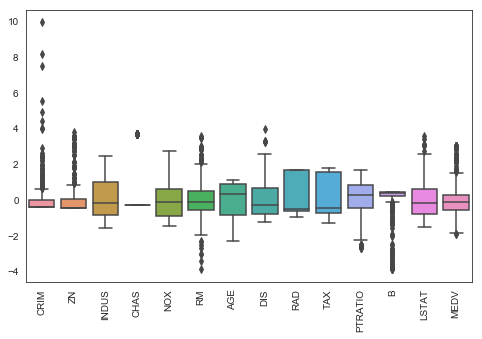

In [6]:
#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Paired scatter plots between features and diagonal histograms of features.

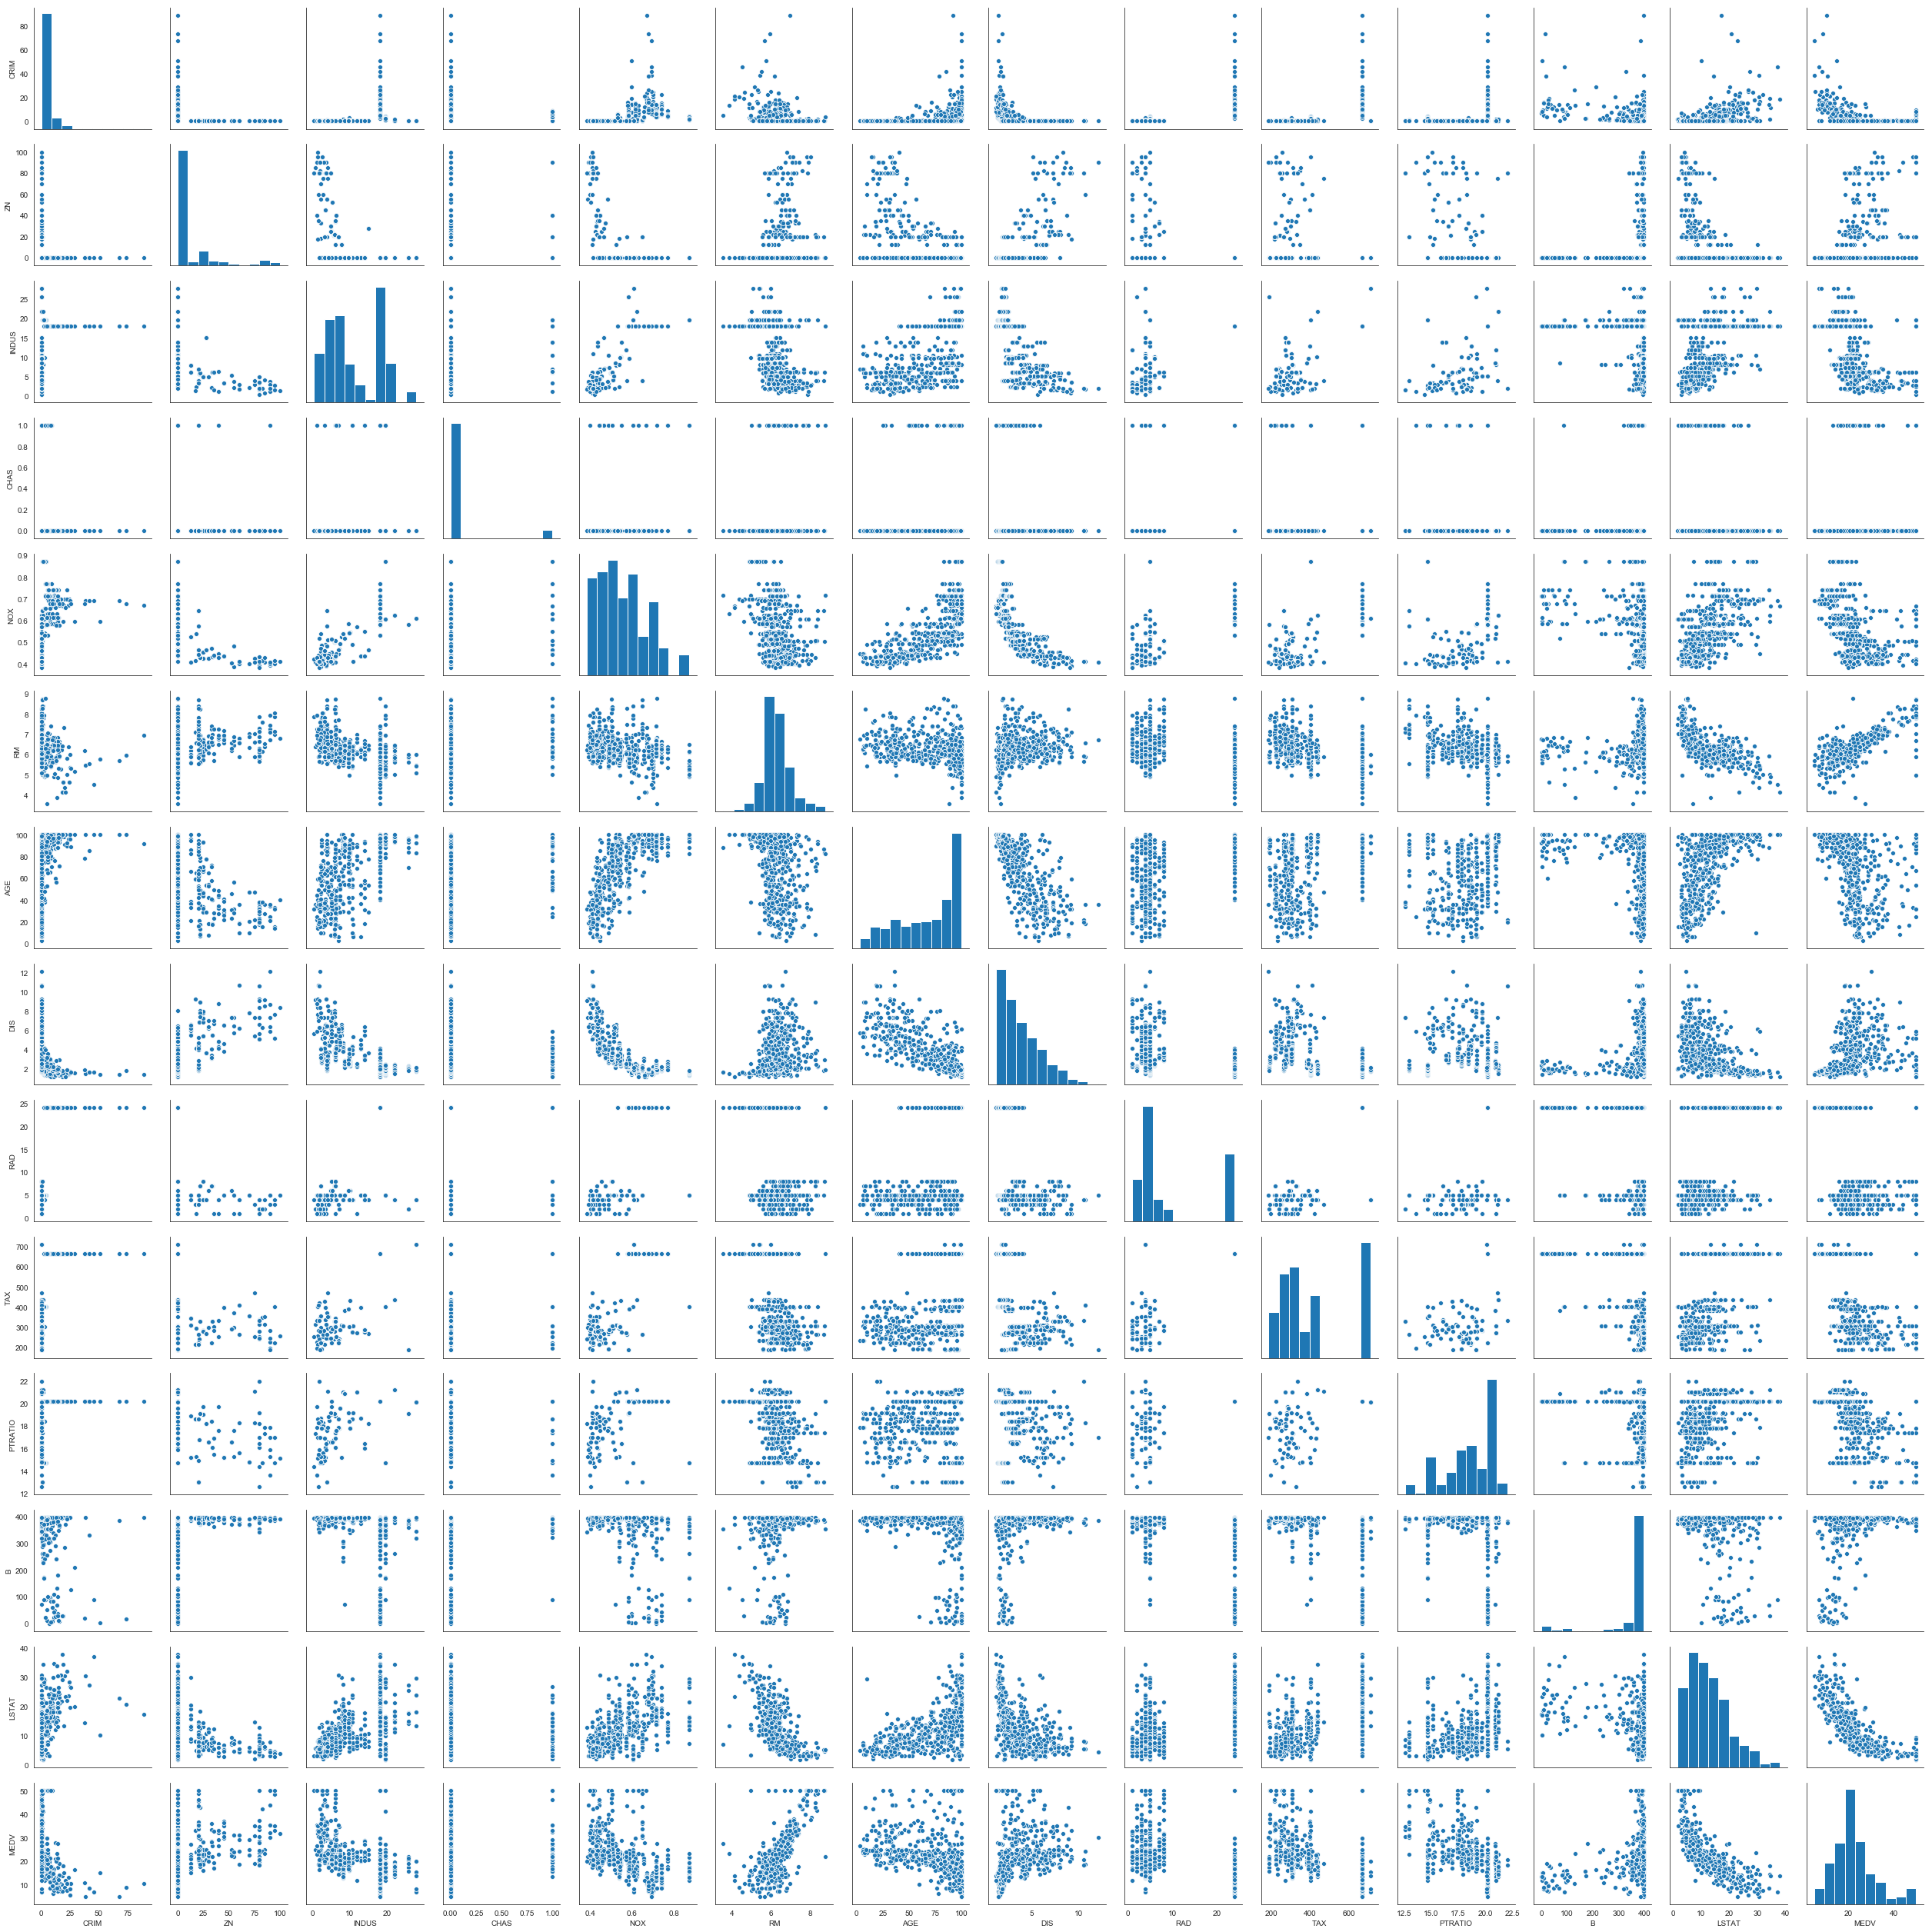

In [7]:
pair_plot = sns.pairplot( df_housing[vars + [target]] )
plt.show()

We see a cluster of house values at the right hand side.

They correspond to clipped house values and we remove them.

In [8]:
idx_high_medv = df_housing['MEDV'] < 50.

print("houses below 50K $:", idx_high_medv.sum())

houses below 50K $: 490


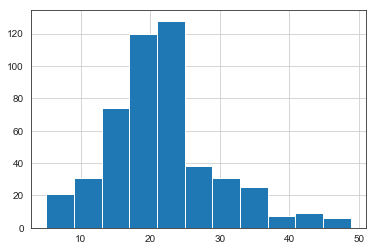

In [9]:
df_housing = df_housing.loc[ idx_high_medv ]

df_housing[target].hist(bins=11)

### Correlations

Crucial for linear regression: if features are correlated Ridge regularization is used to control this.

We give them first as a table including the target.

In [10]:
df_housing.corr().round(decimals=3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.199,0.408,-0.064,0.420,-0.219,0.354,-0.382,0.627,0.584,0.287,-0.384,0.462,-0.450
ZN,-0.199,1.000,-0.527,-0.054,-0.512,0.311,-0.563,0.673,-0.308,-0.303,-0.382,0.176,-0.422,0.405
INDUS,0.408,-0.527,1.000,0.036,0.765,-0.412,0.638,-0.710,0.596,0.718,0.388,-0.363,0.637,-0.600
CHAS,-0.064,-0.054,0.036,1.000,0.086,0.045,0.071,-0.078,-0.033,-0.068,-0.117,0.042,-0.006,0.075
NOX,0.420,-0.512,0.765,0.086,1.000,-0.323,0.728,-0.768,0.612,0.667,0.188,-0.383,0.612,-0.524
RM,-0.219,0.311,-0.412,0.045,-0.323,1.000,-0.268,0.246,-0.196,-0.282,-0.293,0.119,-0.610,0.687
AGE,0.354,-0.563,0.638,0.071,0.728,-0.268,1.000,-0.743,0.452,0.500,0.268,-0.279,0.638,-0.493
DIS,-0.382,0.673,-0.710,-0.078,-0.768,0.246,-0.743,1.000,-0.492,-0.532,-0.247,0.299,-0.536,0.369
RAD,0.627,-0.308,0.596,-0.033,0.612,-0.196,0.452,-0.492,1.000,0.909,0.456,-0.452,0.510,-0.476
TAX,0.584,-0.303,0.718,-0.068,0.667,-0.282,0.500,-0.532,0.909,1.000,0.452,-0.448,0.566,-0.572


We give them next as an annotated heatmap.

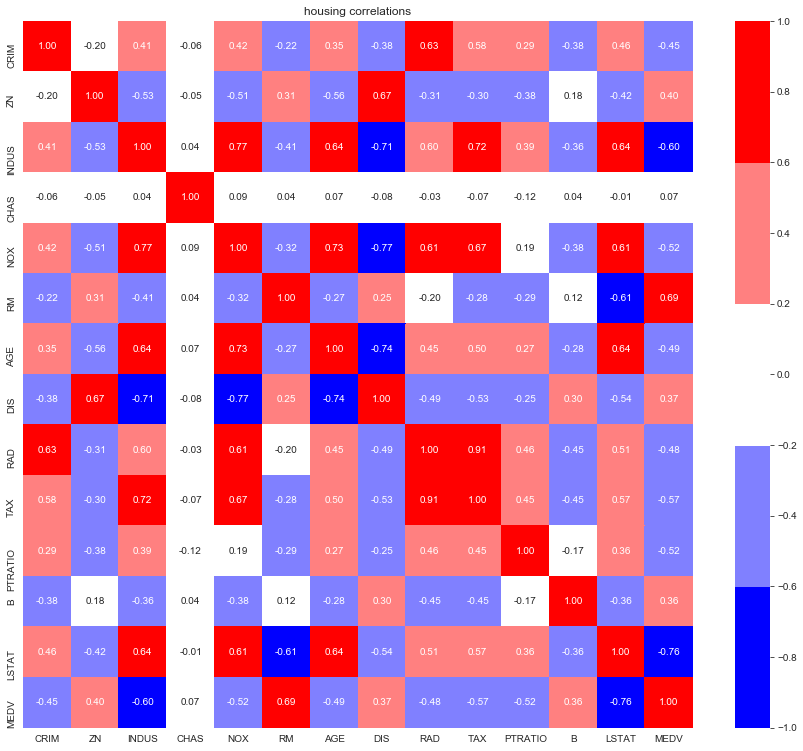

In [11]:
# correlation heatmap
cMap = plt.cm.get_cmap("bwr",lut=5) 

plt.figure( figsize=(15, 13))
plt.title('housing correlations')
h_map = sns.heatmap(df_housing.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=list(df_housing.columns),
                    yticklabels=list(df_housing.columns))

cbar = h_map.collections[0].colorbar
l_ticks = [-1 + k/10. for k in range(0, 21, 2)]
cbar.set_ticks(l_ticks)

## Linear Regression

Just getting started ...
Build a first Ridge model (to be hyperparameterized later).

In [12]:
x = df_housing[vars].values
y = df_housing[target]

b: 21.635918


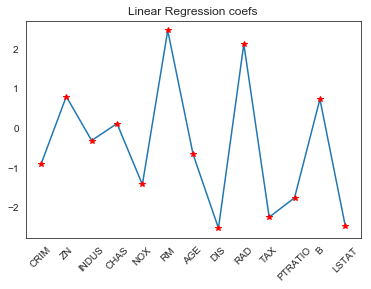

In [13]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
x = std_sc.fit_transform( df_housing[vars].values )
y = df_housing[target].values

linr =  Ridge()
#ajuste sobre la muestra completa, sin split train-test
linr.fit(x, y)

print("b: %f" % linr.intercept_)

nticks = len(linr.coef_)
plt.xticks(range(len(vars)), vars, rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(linr.coef_, '-', linr.coef_, 'r*')

MAE: 2.733		R^2: 0.778


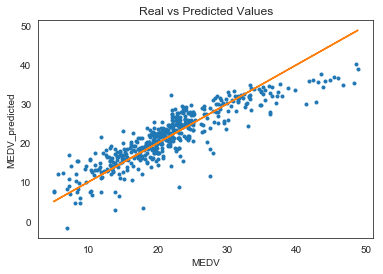

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = linr.predict(x)

print("MAE: %.3f\t\tR^2: %.3f" % (mean_absolute_error(y, y_pred), linr.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

We get a more realistic evaluation through Cross Validation.

In [15]:
from sklearn.model_selection import cross_validate, KFold

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True)
scoring = ['neg_mean_absolute_error', 'r2']

scores = cross_validate(linr, x, y, scoring=scoring, cv=kf)

In [16]:
dir(scores)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores['test_neg_mean_absolute_error'].mean(), scores['test_neg_mean_absolute_error'].std()))

mae_mean: 2.869		mae_std: 0.429


### Finding the optimal `alpha` by CV I

We use first the `r2` scoring..

In this try we won't use a `Pipeline` but work only with the Ridge model.

At the end we save the `GridSearchCV`model in a serialized pickle file.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# SVR hyperpars
linr = Ridge() 

l_alpha    = [10.**k for k in range(-6, 4)] 

param_grid = {'alpha': l_alpha}

n_jobs = 2

n_folds = 10
kf = KFold(n_folds, shuffle=True, random_state=1)

scoring="r2"

t_0 = time.time()
alpha_search_r2 = GridSearchCV(linr, 
                               param_grid=param_grid, 
                               cv=kf, 
                               scoring=scoring, 
                               n_jobs=n_jobs, 
                               return_train_score=True,
                               verbose=True)

alpha_search_r2.fit(x, y)
print("GrdidSearchCV_time: %.f" % (time.time() - t_0))

f_pkl = open("linr_alpha_cv_search_r2_housing.pkl", 'wb') 
pickle.dump(alpha_search_r2, f_pkl)
f_pkl.close()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


GrdidSearchCV_time: 7


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.5s finished


### Checking `alpha`

Recover grid search from pickle file, get best parameter values and check they are OK

In [18]:
f_pkl = open('linr_alpha_cv_search_r2_housing.pkl', mode='rb')
alpha_search_r2 = pickle.load(f_pkl)
f_pkl.close()

In [19]:
best_alpha = alpha_search_r2.best_params_['alpha']

print("alpha\tmin %f" % np.min(l_alpha), "\tbest %f" % best_alpha, "\tmax %f" % np.max(l_alpha))

alpha	min 0.000001 	best 10.000000 	max 1000.000000


alfa = 10.00
best_cv_r2 = 0.758


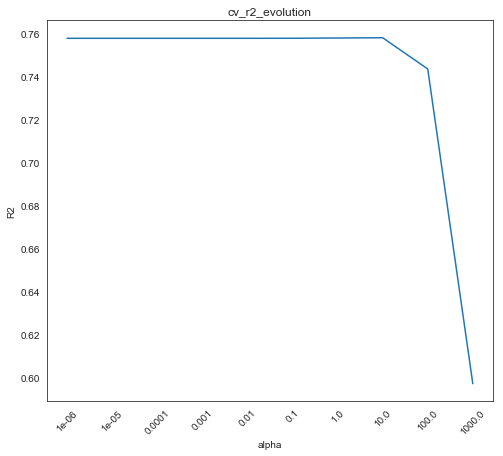

In [20]:
print('alfa = %.2f' % (alpha_search_r2.best_params_['alpha']))
print('best_cv_r2 = %.3f' % (alpha_search_r2.best_score_))

plt.figure(figsize=(8, 7))
plt.title("cv_r2_evolution")
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel("alpha")
plt.ylabel("R2")
_ = plt.plot( alpha_search_r2.cv_results_['mean_test_score'])

### Finding the optimal `alpha` by CV II

We use now the `neg_mean_absolute_error` scoring and work with a pipeline model.

In [21]:
kf = KFold(n_folds, shuffle=True)

linr_estimator = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('linr', Ridge())])
        
l_alpha    = [10.**k for k in range(-6, 4)] 
param_grid = {'linr__alpha': l_alpha}

lr_m = Ridge()
alpha_search_mae = GridSearchCV(linr_estimator, 
                                param_grid=param_grid, 
                                cv=kf, 
                                scoring='neg_mean_absolute_error',
                                return_train_score=True,
                                n_jobs=2, 
                                verbose=1)

alpha_search_mae.fit(x, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std_sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linr', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'linr__alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

We check the CV results as before.

alfa = 10.00
best_cv_mae = 2.842


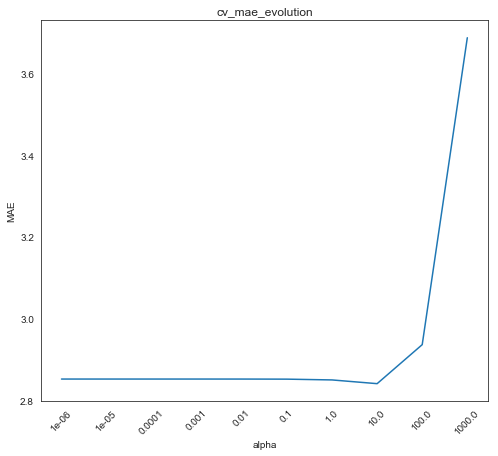

In [22]:
print('alfa = %.2f' % (alpha_search_mae.best_params_['linr__alpha']))
print('best_cv_mae = %.3f' % (-alpha_search_mae.best_score_))

plt.figure(figsize=(8, 7))
plt.title("cv_mae_evolution")
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel("alpha")
plt.ylabel("MAE")
_ = plt.plot( -alpha_search_mae.cv_results_['mean_test_score'])

### Performance by hyperpars

Sort by best CV test score

In [23]:
df_alpha_search_mae = pd.DataFrame.from_dict(alpha_search_mae.cv_results_)

df_alpha_search_mae.sort_values(by='mean_test_score', ascending=False)[['param_linr__alpha', 'mean_test_score']]

,param_linr__alpha,mean_test_score
7,10,-2.842025
6,1,-2.851130
5,0.1,-2.853047
4,0.01,-2.853264
3,0.001,-2.853285
2,0.0001,-2.853288
1,1e-05,-2.853288
0,1e-06,-2.853288
8,100,-2.937354
9,1000,-3.687136


### Testing the final model

We do it by CV, fist using KFold.

In [24]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, ShuffleSplit

best_model = alpha_search_mae.best_estimator_

scores = cross_val_score(best_model, x, y, scoring="neg_mean_absolute_error", cv=kf)

print("KFold mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

KFold mae_mean: 2.828		mae_std: 0.432


And next using ShuffleSplits.

In [25]:
n_splits  = 30
test_size = 0.25

random_state = 1
ssf = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

scores = cross_validate(best_model, x, y, scoring=["neg_mean_absolute_error", 'r2'], cv=ssf)

print("ShuffleSplit mae_mean: %.3f" % (-scores["test_neg_mean_absolute_error"].mean()),
      "\tr2_mean: %.3f" % (scores["test_r2"].mean()))

ShuffleSplit mae_mean: 2.770 	r2_mean: 0.772


Next we get individual CV predictions and plot them against the true values. 

In [26]:
y_pred = np.clip( cross_val_predict(best_model, x, y, cv=kf), 5., 50.)

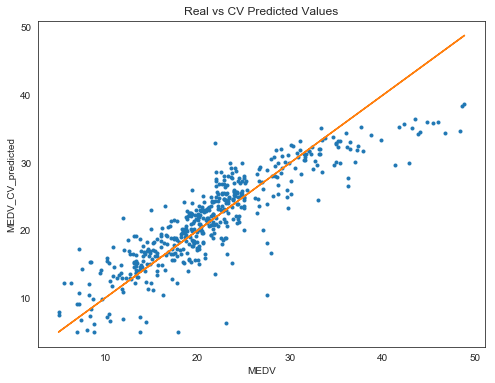

In [27]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Residual Analysis

Finally we compute and analyze the model residuals. Do they meet the regression model assumptions?

mae: 2.797


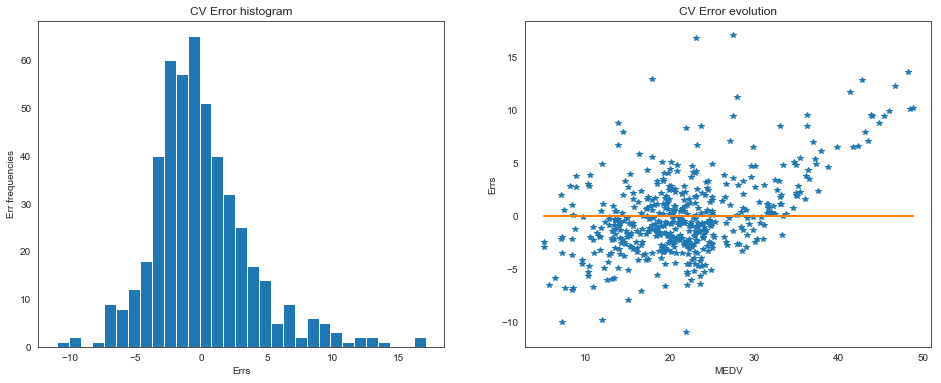

In [28]:
err = y - y_pred

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()